In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

# Generative adverserial networks (GAN's) in PyTorch

Deep neural network are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GAN's however use neural network for a very different purpose: Generative modeling

Generative modeling is an unsupervised learning task in ML that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that possibly could have been drawn from the original dataset

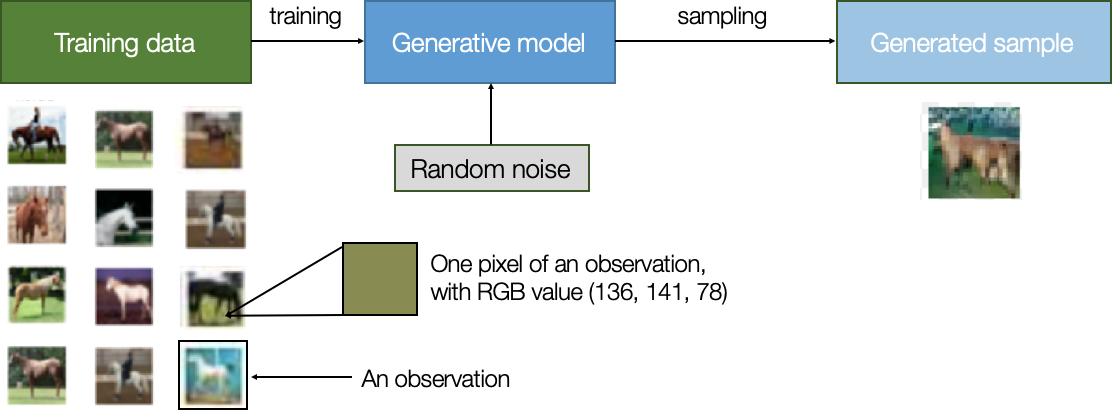

# Discriminative Model

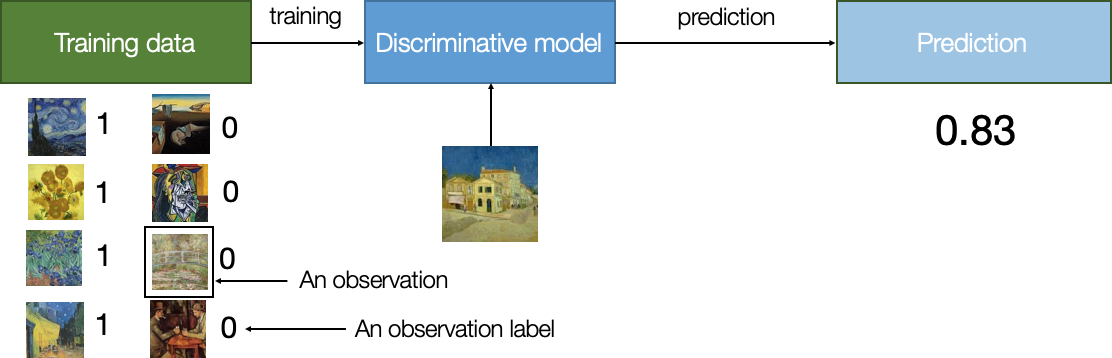

One key difference is that when performing discriminative modeling, each observation in the training data has a label. For a binary classification problem such as our artist discriminator, Van Gogh paintings would be labeled 1 and non–Van Gogh paintings labeled 0. Our model then learns how to discriminate between these two groups and outputs the probability that a new observation has label 1—i.e., that it was painted by Van Gogh.

For this reason, discriminative modeling is synonymous with supervised learning, or learning a function that maps an input to an output using a labeled dataset. Generative modeling is usually performed with an unlabeled dataset (that is, as a form of unsupervised learning), though it can also be applied to a labeled dataset to learn how to generate observations from each distinct class.

The generator model generates a fake sample given a random vector/matrix and the discriminator model attempts to detect whether a given sample is real or fake. Training happens in tandom, we train the disriminator model for a few epochs then train the generator for a few epochs and repeat. This way both the generator and the discriminator get better at doing there job. this rather simple approach can lead to some astounding results.

### Steps to follow

* define a problem statement
* Load the data(with transform and normalization)
     * Denormalize for visual inspection of samples
* Define the discriminator network
     * study the activation function: leaky ReLU
* Defien the generator network
     * explain the output activation function: TanH
     * look at some sample outputs
* Define losses, optimizers and helper functions for the training
     * For discriminator
     * For generator
* Train the model
     * save intermediate generated images to file
* look at some outputs
* save the models

In [3]:
mnist = MNIST(root = "/media/souravsaini/Data/POP_OS/dl/pytorch/pytorch",
              train=True, 
              download=True, 
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Since the tensor of the image ranges from 0 to 1, and we want the mean from -1 to 1. Therefore we give give the mean of 0.5 so that it reaches to the range of -0.5 to 0.5. then we provide the standard deviation of 0.5 so that it ranges from -1 to 1

In [4]:
img, label = mnist[0]
print("lable: ", label)
print(img[:,10:15, 10:15])
torch.min(img), torch.max(img)

lable:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

let us define a helper fxn to denormalize the tensor and view the images. This fxn will also be useful for viewing the generated images

In [5]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

Label:  5


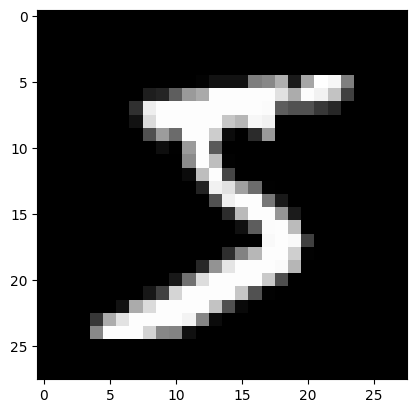

In [6]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label: ', label)

In [7]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

first batch
torch.Size([100, 1, 28, 28])
tensor([2, 0, 6, 0, 0, 8, 2, 2, 9, 4, 2, 7, 9, 8, 3, 4, 8, 6, 0, 7, 6, 8, 2, 5,
        8, 8, 6, 7, 5, 2, 2, 5, 5, 2, 4, 1, 3, 9, 0, 8, 2, 1, 1, 9, 2, 4, 4, 1,
        3, 4, 7, 6, 1, 0, 6, 1, 4, 4, 8, 1, 3, 4, 7, 4, 2, 7, 1, 8, 4, 7, 3, 9,
        5, 1, 0, 5, 5, 4, 8, 4, 8, 6, 1, 8, 4, 6, 3, 9, 6, 7, 2, 1, 6, 9, 5, 3,
        3, 2, 8, 8])


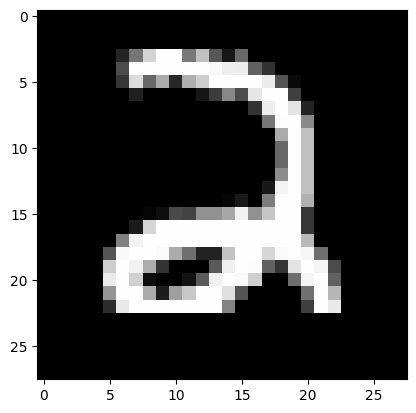

In [8]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Disciminator model

In [10]:
image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

### LeakyReLU

Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learnt during training. This type of activation function is popular in tasks where we we may suffer from sparse gradients, for example training generative adversarial networks

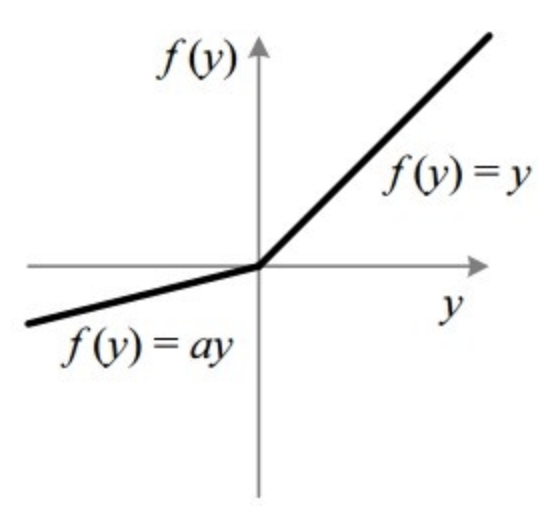

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result it makes the gradient of 0 in the back propagation pass, it passes a small negative gradient.

Just like any other binary classification model the output of the discriminator is a single number between 0 and 1 which can be interpreted as the probability of the input image being fake i.e. generated

In [11]:
D.to(device);

# Generator function

The input to the generator is typically a vector or a matrix which is used for generating an image. Once again to keep things simple we'll use a feedforward neural network with 3 layers and the output will be a vector of size 784 which can be transformed to a 28x28 pixel image

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

The ReLU activation is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the colour space of the training distribution. Within the discriminator we found the leaky rectified activation to work well escpacially for higher resolution modeling

Note that since the outputs of the Tanh activation lie in the range [-1,1] we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output

In [14]:
# G.to(device);

In [15]:
torch.rand(2, latent_size)

tensor([[0.1782, 0.9549, 0.2160, 0.6660, 0.6616, 0.5016, 0.8056, 0.7969, 0.4033,
         0.4874, 0.0728, 0.4625, 0.0019, 0.9338, 0.2145, 0.7229, 0.8902, 0.2465,
         0.8564, 0.2517, 0.1115, 0.9656, 0.0814, 0.1938, 0.8823, 0.5001, 0.8441,
         0.3198, 0.6663, 0.0586, 0.0510, 0.6961, 0.4891, 0.0076, 0.4276, 0.1974,
         0.5163, 0.0121, 0.2852, 0.6502, 0.9253, 0.6902, 0.8670, 0.5738, 0.2749,
         0.4110, 0.9074, 0.4410, 0.5084, 0.1653, 0.4989, 0.7478, 0.4303, 0.6031,
         0.9836, 0.3498, 0.8664, 0.4699, 0.5382, 0.3284, 0.2969, 0.0493, 0.3657,
         0.1475],
        [0.3887, 0.2949, 0.6257, 0.7768, 0.2333, 0.4002, 0.9694, 0.4021, 0.0722,
         0.0450, 0.7087, 0.7914, 0.1835, 0.4927, 0.5220, 0.7104, 0.5360, 0.0770,
         0.4977, 0.8290, 0.7391, 0.4283, 0.5201, 0.6092, 0.8508, 0.6379, 0.0624,
         0.5625, 0.8943, 0.4488, 0.1521, 0.8028, 0.6244, 0.5836, 0.2854, 0.8228,
         0.0020, 0.4668, 0.7351, 0.0583, 0.7468, 0.9855, 0.6852, 0.7913, 0.6509,
         0

In [16]:
torch.randn(2, latent_size)         # keep in mind that in this model rand is not used, randn is used

tensor([[-0.7833,  0.9561,  0.0041,  1.1940, -0.2220, -0.3524,  0.5078,  0.0616,
          1.0761, -1.8666,  0.6320,  1.2868, -0.7876, -0.9609, -0.2459, -0.2187,
          1.3850, -1.4712,  0.5020,  0.5853, -1.2504,  1.7659,  0.2573, -1.5449,
         -1.9756, -0.1090, -0.3442, -0.3420, -1.0736,  0.1202, -0.8139, -0.8041,
         -1.0272,  0.0929, -0.9458, -0.7109,  0.4808,  0.6579,  0.3509, -0.5679,
         -1.1837, -1.3520,  0.4855, -0.3475, -0.3675, -1.4223, -0.3230,  0.3149,
          1.2250, -0.4634, -0.8586,  0.2327, -1.4642, -0.6413,  2.3163, -1.1407,
          0.7331, -0.3230, -0.6752,  1.4590, -0.5559, -0.9669, -0.6623, -0.5009],
        [ 0.6297,  1.1215,  0.1118,  0.4466,  0.9349, -1.0394,  0.5493, -0.5821,
         -0.5051,  0.3555, -0.0611,  0.8802, -0.0715, -0.3808, -1.2941,  0.4532,
         -0.0698,  0.3423,  0.4742, -0.1703, -1.4201, -1.5589, -0.5267,  0.0504,
          0.4901,  1.8355,  2.5596, -1.6047, -0.0713,  1.0627, -0.8041,  0.8129,
          0.5724, -1.3328, 

In [17]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [18]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

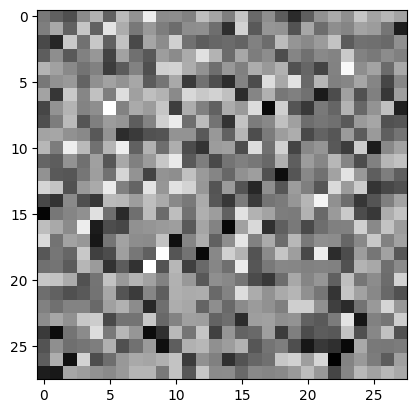

In [19]:
plt.imshow(gen_imgs[0], cmap='gray')

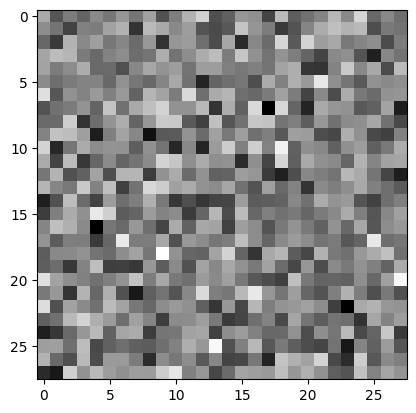

In [20]:
plt.imshow(gen_imgs[1], cmap='gray')

In [21]:
# CUDA_LAUNCH_BLOCKING=1
G.to(device);

# Discriminator Trianing

Since the discrimator is binary classification model we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.
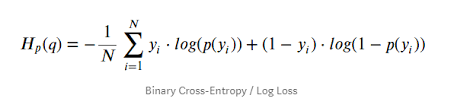

In [22]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [23]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator(images):
    # create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Combine loss
    d_loss = d_loss_real + d_loss_fake
    
    # reset gradient 
    reset_grad()
    
    # compute gradient 
    d_loss.backward()
    
    # adjustthe parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

# Geneartor Training

Since the outputs of the generator are vectors its not obvious how we can train the generator. This is where we employ a rather elegant "trick". Since we know that the output images are "generated" or "fake", we can pass them into the discriminator and compare the output of the discriminator with the ground truth(i.e all fake), and use that to calculate the loss for the generator

In [24]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [25]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)
    
    # Backup and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images


# Training the Model

lets create a directory where we can save intermidiate outputs from the generator to visually inspect the progress of the model

In [26]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for the visual comparision while looking at the generated images 

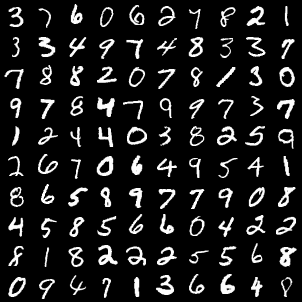

In [27]:
from IPython.display import Image
from torchvision.utils import save_image

# save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
    break
    
Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. 

Saving fake_images-0000.png


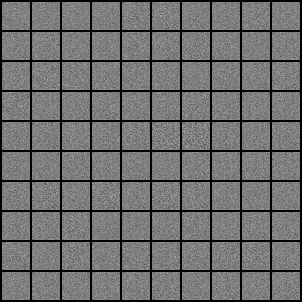

In [28]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)
    
# before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

now we are ready to train the model. In each epoch we train the discriminator first and then the generator. 

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load a batch and transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0497, g_loss: 4.2749, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0983, g_loss: 5.2999, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.1170, g_loss: 5.4340, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0409, g_loss: 6.4174, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.4955, g_loss: 3.1361, D(x): 0.80, D(G(z)): 0.13
Epoch [1/300], Step [600/600], d_loss: 0.1650, g_loss: 4.6502, D(x): 0.93, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3511, g_loss: 4.4375, D(x): 0.86, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.5725, g_loss: 4.1171, D(x): 0.76, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.3227, g_loss: 3.5457, D(x): 0.90, D(G(z)): 0.11
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.6735, g_loss: 3.6008, D(x): 0.88, D(G(z)): 0.28
Epoch [3/300], Step [400/6

In [27]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

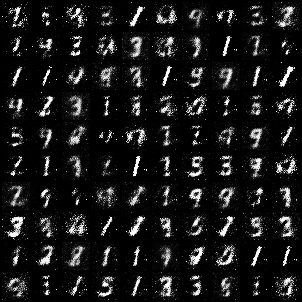

In [30]:
Image('./samples/fake_images-0030.png')

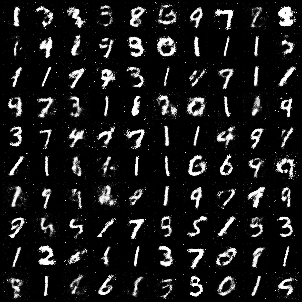

In [31]:
Image('./samples/fake_images-0100.png')

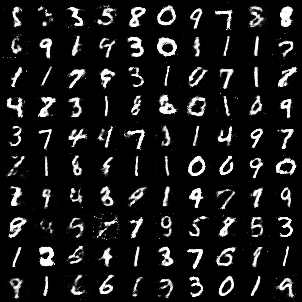

In [32]:
Image('./samples/fake_images-0200.png')

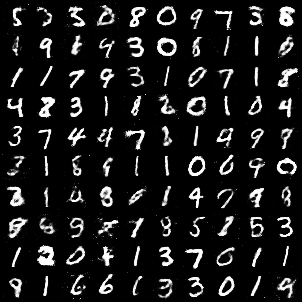

In [33]:
Image('./samples/fake_images-0300.png')